### 1 - Configuraciones Iniciales

In [6]:
# Instalando pmdarima y keras tuner
import os
import subprocess
import pkg_resources

# Verificar la versión actual de numpy
required_numpy_version = '1.26.4'
installed_numpy_version = pkg_resources.get_distribution("numpy").version

# Si la versión no es la requerida, la instalamos y reiniciamos el entorno
if installed_numpy_version != required_numpy_version:
    print(f"Instalando numpy=={required_numpy_version} (actual: {installed_numpy_version}) y reiniciando entorno...")
    subprocess.run(['pip', 'install', f'numpy=={required_numpy_version}', '--quiet'])
    os.kill(os.getpid(), 9)

# Si ya está bien, continuar con el resto
!pip install pmdarima --quiet
!pip install keras-tuner --quiet

In [7]:
# Importando librerías necesarias
# Luego tengo que limpiar esta celda
import os
import io
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from google.colab import files

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima
from pmdarima.arima import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers

import keras_tuner as kt
from kerastuner.tuners import RandomSearch

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
import shutil

# Fijando semilla para permitir reproducibilidad
SEED = 42

# Función para forzar reproducibilidad en TensorFlow, NumPy y Python
def reset_seeds(seed=SEED):
    # configurar variables de entorno
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    # Para TF>=2.13 (si lo tienes):
    try:
        tf.config.experimental.enable_op_determinism(True)
    except Exception:
        pass
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Esto reduce el paralelismo de TensorFlow para Limitar hilos para reducir no-determinismo
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.threading.set_inter_op_parallelism_threads(1)

reset_seeds(SEED)

# Ajustar la resolución de las figuras de Matplotlib a 110 DPI
plt.rcParams["figure.dpi"] = 110

In [8]:
# Subir archivo dataset limpio con datos de contaminantes y meteorológicos
print("Sube el archivo con el dataset limpio (formato CSV, columnas: fecha, PM2.5, PM10, NO2, SO2, CO, O3, temperatura, humedad, etc.)")

uploaded_clean_dataset = files.upload()

# Visualizar confirmación de carga y nombre del archivo
for fn in uploaded_clean_dataset.keys():
    print(f"Archivo {fn} subido correctamente, listo para análisis.")

Sube el archivo con el dataset limpio (formato CSV, columnas: fecha, PM2.5, PM10, NO2, SO2, CO, O3, temperatura, humedad, etc.)


Saving dataset_tratado_contaminantes_meteorologicos.csv to dataset_tratado_contaminantes_meteorologicos (1).csv
Archivo dataset_tratado_contaminantes_meteorologicos (1).csv subido correctamente, listo para análisis.


In [9]:
# Crear DataFrame con el archivo cargado
for fn in uploaded_clean_dataset.keys():
    df_clean = pd.read_csv(fn)
    print(f"DataFrame creado correctamente con {df_clean.shape[0]} filas y {df_clean.shape[1]} columnas.")

# Visualizar las primeras filas para comprobar la carga
df_clean.info()

DataFrame creado correctamente con 17520 filas y 8 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    17520 non-null  object 
 1   PM2.5   17520 non-null  float64
 2   PM10    17520 non-null  float64
 3   CO      17520 non-null  float64
 4   O3      17520 non-null  float64
 5   wspd    17520 non-null  float64
 6   temp    17520 non-null  float64
 7   dwpt    17520 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.1+ MB


## 2 - Descripción de Variables a usar


| Variable | Descripción | Importancia para el modelado de PM2.5 |
|---|---|---|
| **time** | Fecha y hora de la observación (UTC). | Permite análisis temporal, creación de lags, estacionalidad y tendencias. |
| **PM2.5 (µg/m³)** | Partículas ≤ 2.5 µm, **variable objetivo**. | Indicador clave de contaminación, afecta salud y visibilidad. |
| **PM10 (µg/m³)** | Partículas ≤ 10 µm, incluye PM2.5. | Altamente correlacionado, aporta información de polvo y emisiones gruesas. |
| **CO (mg/m³)** | Monóxido de carbono, contaminante de combustión incompleta (tráfico, calefacción). | Correlaciona con PM2.5 como trazador de emisiones directas. |
| **O3 (µg/m³ o ppb)** | Ozono troposférico, contaminante secundario formado por reacciones fotoquímicas. | Suele tener relación inversa con PM2.5, especialmente en verano. |
| **wspd (m/s)** | Velocidad del viento. | Vientos fuertes dispersan contaminantes; vientos bajos permiten acumulación. |
| **temp (°C)** | Temperatura del aire. | Influye en la formación y dispersión de partículas finas. |
| **dwpt (°C)** | Punto de rocío. | Temperatura a la que el aire debe enfriarse para que se sature con vapor de agua y se produzca condensación. |

Vamos a gráficar la serie temporal de nuestra variable objetivo para ver como se comporta a simple vista.

In [10]:
# Crear copia segura de df_clean
df_clean_time = df_clean.copy()

# Convertir 'time' a datetime
df_clean_time['time'] = pd.to_datetime(df_clean_time['time'], errors='coerce')

# Eliminar filas con 'time' NaT y establecer como índice con frecuencia horaria
df_clean_time = df_clean_time.dropna(subset=['time']).set_index('time').asfreq('h')

# Verificar
df_clean_time.head()

,PM2.5,PM10,CO,O3,wspd,temp,dwpt
time,,,,,,,
2022-01-01 00:00:00,23.6875,37.272727,0.500000,8.781538,6.925,5.525,4.200
2022-01-01 01:00:00,19.2500,30.000000,0.466667,9.619231,4.150,4.850,3.650
2022-01-01 02:00:00,19.2500,21.923077,0.433333,10.962308,4.775,4.300,3.200
2022-01-01 03:00:00,13.7500,15.923077,0.400000,13.469231,7.125,4.250,2.650
2022-01-01 04:00:00,14.5000,15.769231,0.300000,14.371538,6.025,3.225,1.325


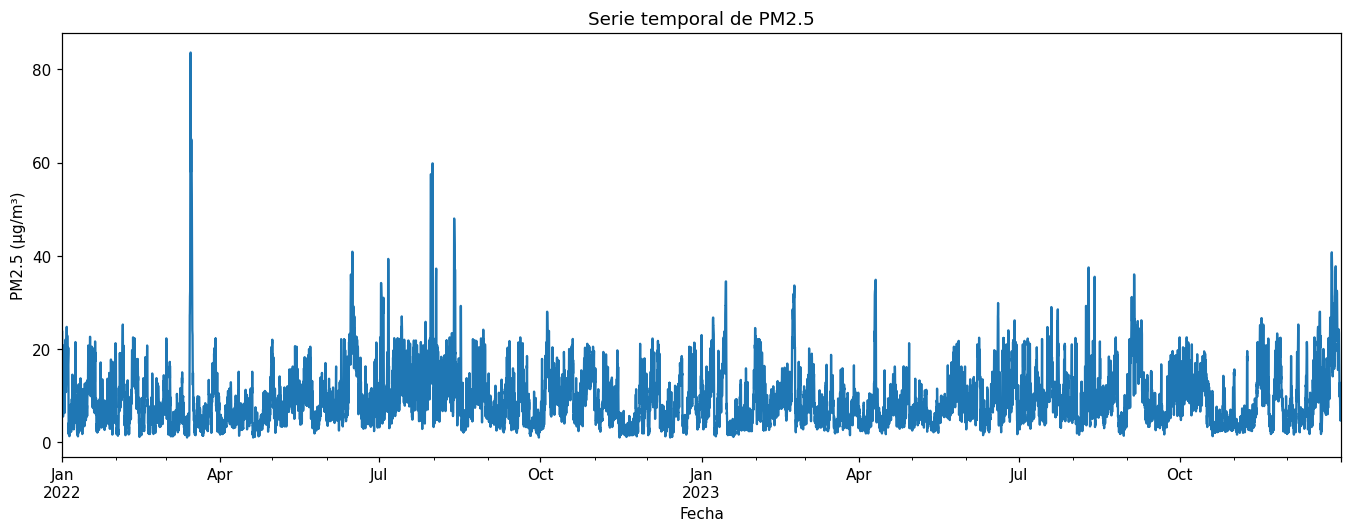

In [11]:
# Gráficar la serie temporal de nuestra variable objetivo (PM2.5)
df_clean_time['PM2.5'].plot(figsize=(15,5))
plt.title('Serie temporal de PM2.5')
plt.xlabel('Fecha')
plt.ylabel('PM2.5 (µg/m³)')
plt.show()

De esta gráfica no podemos confirmar si la serie es estacionaria o no, lo cúal es necesario para poder realizar nuestra predicción usando ARIMA, así que debemos estudiar más a fondo nuestra serie temporal mediante otros tipos de anális.

Pero primero vamos a cambiar la columna 'time' a formato datetime ya que lo necesitaremos para el resto de nuestro análisis. Esto para:
- Facilitar predicciones basadas en tiempo.
- Permitir detección y modelado de estacionalidades.

Empezamos nuestro análisis con la descomposición de nuestra serie temporal.

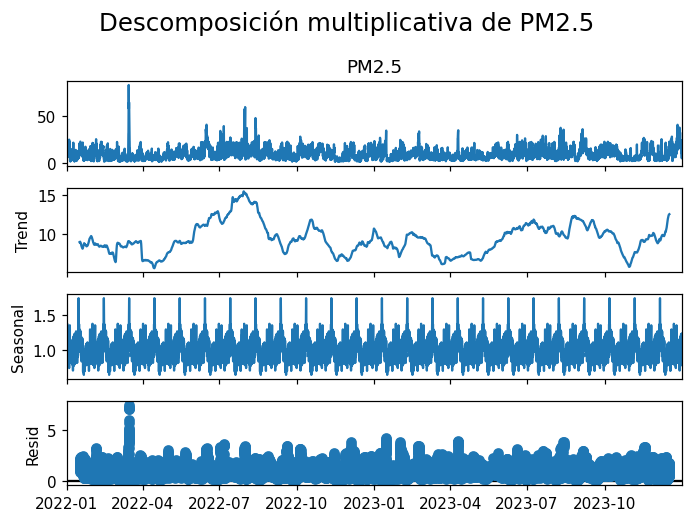

In [12]:
# Descomposición estacional
decomp = seasonal_decompose(df_clean_time['PM2.5'], model='multiplicative',period = 720 ) #24 horas para los 30 dias de un mes.

# Graficar la descomposición
decomp.plot()
plt.suptitle('Descomposición multiplicativa de PM2.5', fontsize=16)
plt.tight_layout()
plt.show()

En la serie original se observan fluctuaciones horarias y picos elevados, reflejando variabilidad típica en áreas urbanas debido a actividades humanas y condiciones meteorológicas.

El componente de tendencia muestra un ligero aumento de PM2.5 únicamente hacia finales del segundo año, lo que podría reflejar un deterioro puntual en la calidad del aire o cambios transitorios en las fuentes de emisión. Sin embargo, en general, la serie temporal no presenta una tendencia sostenida en el tiempo, manteniéndose estable en la mayor parte del periodo analizado. Por lo que pareciera que la serie es estacionaria d=0 en nuestro modelo.

La estacionalidad revela patrones  con periodicidad de 720 horas, lo cual justifica el uso de modelos SARIMAX con s=720, que permiten capturar esta estructura estacional y mejorar la predicción de la calidad del aire

Finalmente, los residuales capturan variabilidad no explicada por la tendencia o estacionalidad, destacando eventos atípicos como incendios o inversiones térmicas. Esto justifica el uso de modelos avanzados y la incorporación de variables exógenas para mejorar la predicción de PM2.5 en sistemas de alerta temprana.

<Figure size 1100x440 with 0 Axes>

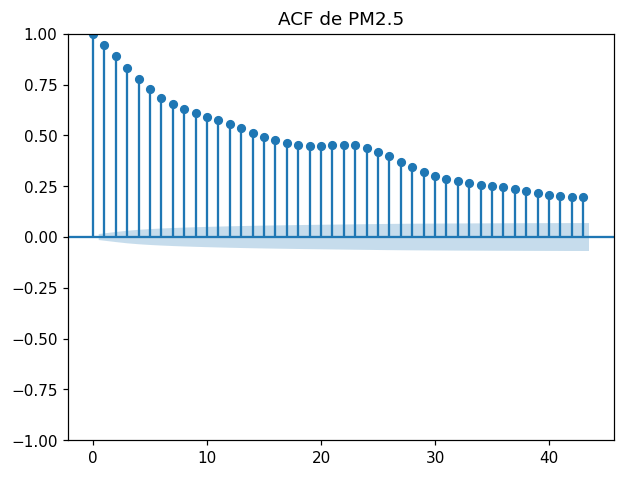

<Figure size 1100x440 with 0 Axes>

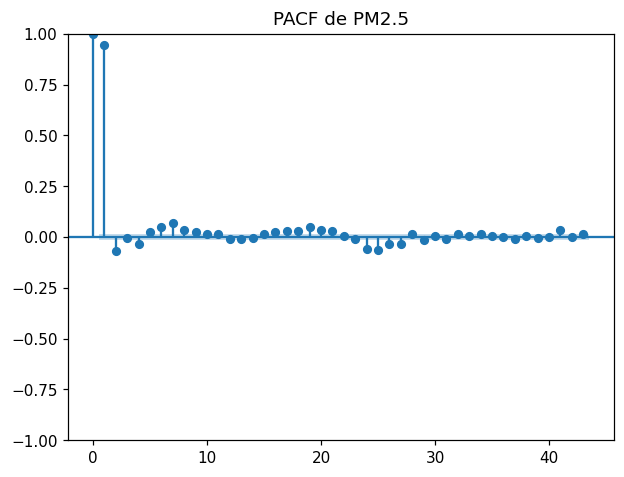

In [13]:
# Series a analizar
serie = df_clean_time['PM2.5']

# ACF
plt.figure(figsize=(10,4))
plot_acf(serie.dropna())
plt.title('ACF de PM2.5')
plt.show()

# PACF
plt.figure(figsize=(10,4))
plot_pacf(serie.dropna(), method='ywm')
plt.title('PACF de PM2.5')
plt.show()

El análisis de autocorrelación parcial (PACF) muestra un pico significativo en el primer lag y, en menor medida, en el segundo, reduciéndose luego a valores cercanos a cero. Este patrón sugiere que la incorporación 1 o 2 términos auto regresivos ( p = 1 o p=2) sería adecuada en el ajuste del modelo ARIMA sobre la serie diferenciada de PM2.5, permitiendo capturar la inercia temporal que caracteriza este contaminante.

Por otro lado, el gráfico de autocorrelación (ACF) muestra un descenso gradual sin un punto de corte definido, indicando persistencia en las correlaciones a lo largo de los rezagos. Este patrón sugiere que no existe un orden de rezago claro para el componente MA (Moving Average), por lo que no es posible determinar un q exacto visualmente.

El patrón de decrecimiento de ACF es característico de series no estacionarias, donde las correlaciones no se disipan rápidamente como ocurre en una serie estacionaria. Puede ocurrir que la serie tiene alta autocorrelación pero sin tendencia, por ejemplo, si hay ciclos estacionales fuertes (semanal y diaria).

Para finalmente comprobar si la serie tiene estacionaridad o no, aplicaremos la prueba de Dickey-Fuller aumentada (ADF).

In [14]:
# Aplicar prueba ADF
adf_test = adfuller(serie, autolag='AIC')

# Imprimir resultados
print(f"ADF Statistic: {adf_test[0]:.4f}")
print(f"p-value: {adf_test[1]:.4f}")

# Evaluación rápida
if adf_test[1] < 0.05:
    print(" La serie es estacionaria (rechaza H0)")
else:
    print(" La serie NO es estacionaria (no se rechaza H0), se recomienda diferenciar.")

ADF Statistic: -12.2270
p-value: 0.0000
 La serie es estacionaria (rechaza H0)


De lo anterior, concluimos que nuestra serie es estacionaria, por lo que sería correcto utilizar un d=0, obteniendo así un modelo a utilizar SARMAX.

## 3 - Entrenamiento de Modelos

## 3.1 - SARIMAX

In [15]:
# Variable objetivo y variables predictoras
target_col = 'PM2.5'
feature_cols = ['PM10','CO', 'O3', 'wspd', 'temp', 'dwpt'] #Variables con mayor correlación con respecto a la variable objetivo

# Definición de traing y test sets
training_y = df_clean_time[target_col].iloc[:13104] # Filas 0-13104 representan el primer año y medio. Desde inicio del 2022 hasta 30 de Junio, 2023.
test_y = df_clean_time[target_col].iloc[13104:17520] # Filas 13104 17520 representan el período entre el año y medio hasta final del segundo año. Desde 30 de Junio, 2023 hasta final del 2023.
training_X = df_clean_time[feature_cols].iloc[:13104]
test_X = df_clean_time[feature_cols].iloc[13104:17520]


print(f"Training: {len(training_y)} registros ({training_y.index.min()} → {training_y.index.max()})")
print(f"Test: {len(test_y)} registros ({test_y.index.min()} → {test_y.index.max()})")

Training: 13104 registros (2022-01-01 00:00:00 → 2023-06-30 23:00:00)
Test: 4416 registros (2023-07-01 00:00:00 → 2023-12-31 23:00:00)


In [16]:
# # Busqueda de mejor modelo
# sarimax_model_h = auto_arima(
#     y=training_y,
#     exogenous=training_X,
#     seasonal=True,
#     m=7,                         # Se deberia utilizar una estacionalidad de 720 (1 mes de estacionalidad). Ya que con 1 mes se puede observar estacionalidad concreta. Pero desafortunadamente al intentarlo, no corre la celda.
#     start_p=1, max_p=2,          # El PACF mostró p en 1 o 2 como valores razonables.
#     start_q=1, max_q=2,          # ACF decae lentamente. Probamos q=1 o q=2
#     start_P=0, max_P=2,
#     start_Q=0, max_Q=2,
#     d=0,                         # según ADF, la serie es estacionaria
#     D=None, max_D=1,             # que el modelo decida si necesita diff. estacional
#     information_criterion='aic', # más flexible que BIC
#     stepwise=True,
#     trace=True,
#     suppress_warnings=True,
#     n_jobs=1,
#     enforce_stationarity=False,  # Asegura que los coeficientes del modelo AR produzcan una serie no estacionaria
#     enforce_invertibility=False  # Asegura que el componente MA sea invertible lo que garantiza una unica representación del modelo
# )

# # Mostrar resumen del modelo seleccionado

# print(sarimax_model_h.summary())

RMSE: 3.86
MAE: 2.49
R^2: 0.6655


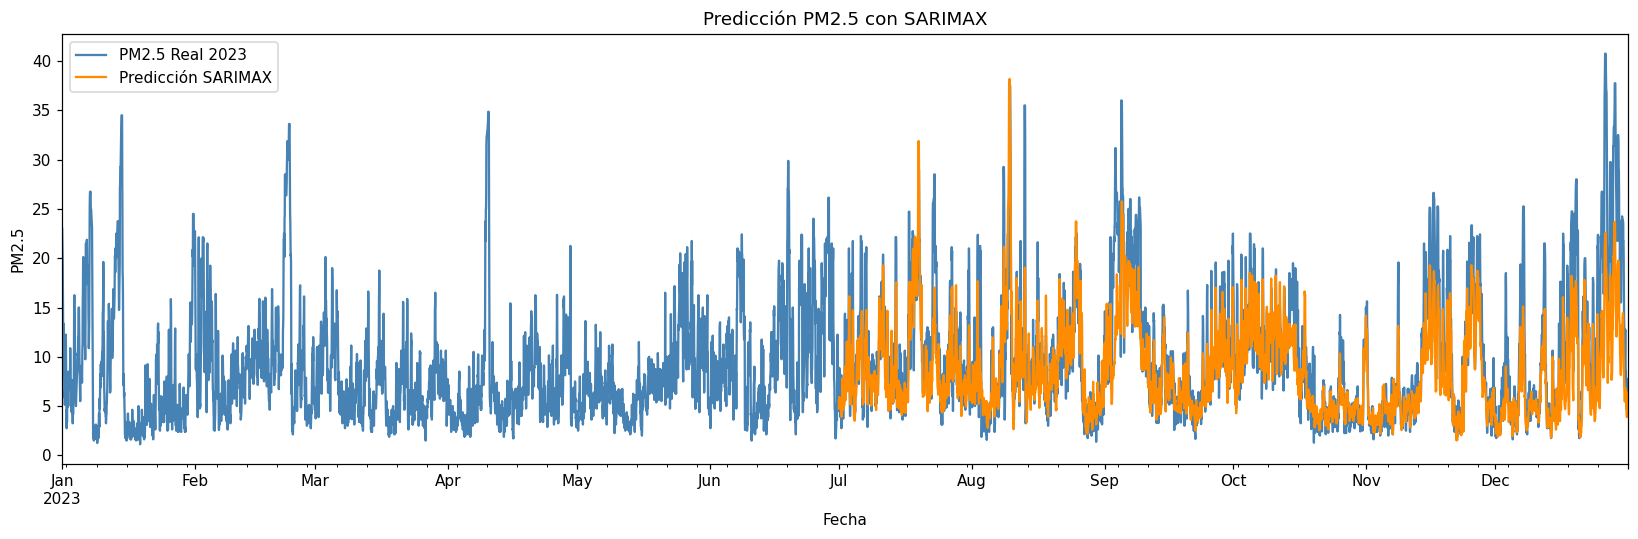

In [37]:
# Best model:  ARIMA(2,0,0)(1,0,2)[7] intercept ARIMA(0,0,4)(0,1,1)[7]

# Definición manual del modelo SARIMAX con los parámetros encontrados:


sarimax_model_h = SARIMAX(
    endog=training_y,
    exog=training_X,
    order=(2, 0, 0),
    seasonal_order=(1, 0, 2, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Ajustar el modelo
sarimax_h_result = sarimax_model_h.fit(disp=False)

# Predecir para el período de test
arimax_predictions = sarimax_h_result.predict(
    start=test_y.index[0],
    end=test_y.index[-1],
    exog=test_X
)

# Calcular métricas
mse = mean_squared_error(test_y, arimax_predictions)
rmse = mse ** 0.5
mae = mean_absolute_error(test_y, arimax_predictions)
r2 = r2_score(test_y, arimax_predictions)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2: {r2:.4f}")

# Graficamos resultados
plt.figure(figsize=(15,5))

# Mostrar TODO 2023
df_clean_time[target_col]['2023-01-01':'2023-12-31'].plot(label='PM2.5 Real 2023', color='steelblue')

# Mostrar SOLO predicción en la segunda mitad de 2023
arimax_predictions.plot(label='Predicción SARIMAX', color='darkorange')

plt.title('Predicción PM2.5 con SARIMAX')
plt.xlabel('Fecha')
plt.ylabel('PM2.5')
plt.legend()
plt.tight_layout()
plt.show()

## 3.2 - SARIMAX A NIVEL DIARIO

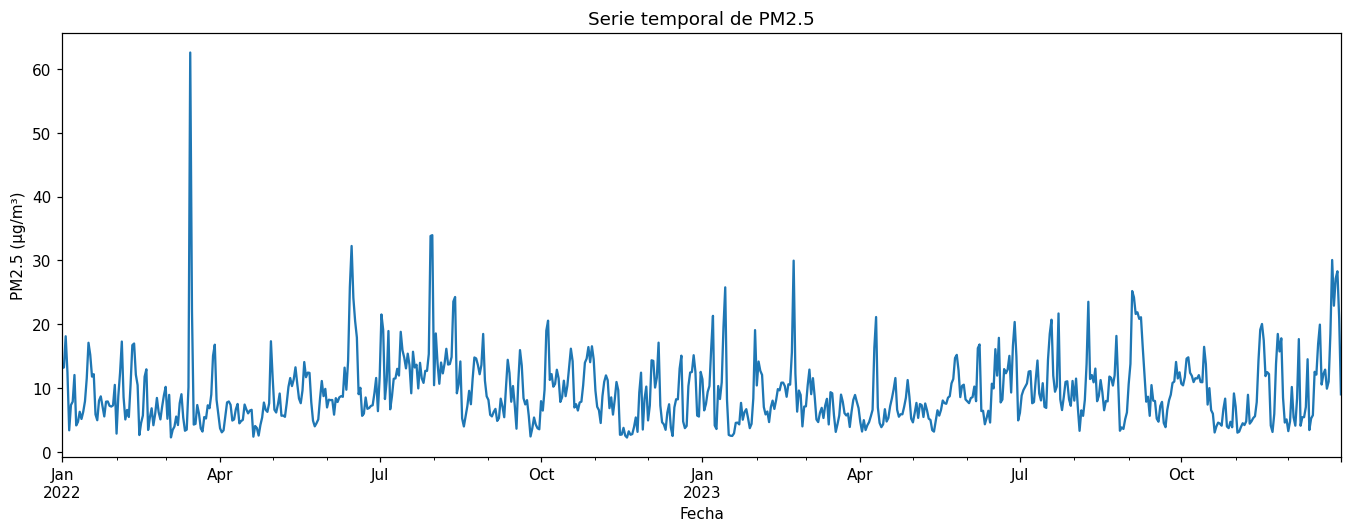

In [18]:
# Agregar por día
df_daily =df_clean_time.resample('D').mean()

# Gráficar la serie temporal de nuestra variable objetivo (PM2.5)
df_daily['PM2.5'].plot(figsize=(15,5))
plt.title('Serie temporal de PM2.5')
plt.xlabel('Fecha')
plt.ylabel('PM2.5 (µg/m³)')
plt.show()

Empezamos nuestro análisis con la descomposición de nuestra serie temporal.

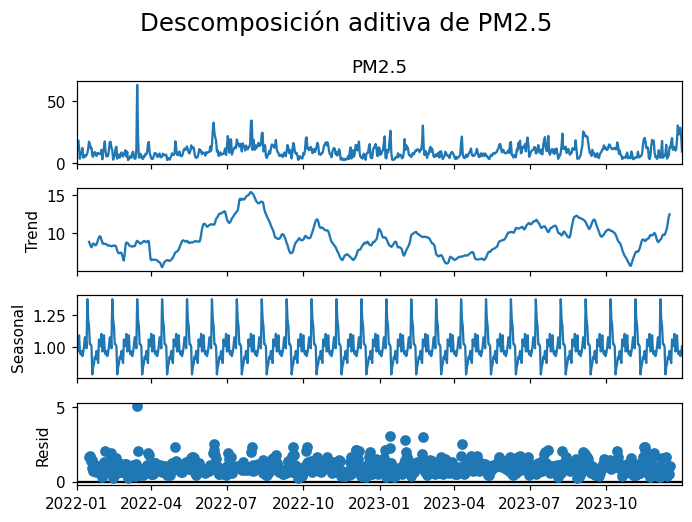

In [19]:
# Descomposición estacional
decomp = seasonal_decompose(df_daily['PM2.5'], model='multiplicative',period =30) #30 dias del año.

# Graficar la Descomposición
decomp.plot()
plt.suptitle('Descomposición aditiva de PM2.5', fontsize=16)
plt.tight_layout()
plt.show()

La descomposición aditiva de la serie PM2.5 muestra que los valores observados se pueden explicar mediante la combinación de una tendencia, una componente estacional y un residuo. La tendencia refleja un comportamiento de mediano plazo con picos y caídas suaves, especialmente notables entre mediados de 2022 y 2023. Esta tendencia sugiere variaciones asociadas a factores externos como condiciones climáticas o cambios en la actividad humana, que afectan los niveles promedio de contaminación en el tiempo.

La componente estacional revela un patrón cíclico claro, repetitivo en intervalos regulares, lo que indica la presencia de factores recurrentes que influyen en la concentración de PM2.5. Los residuos son en su mayoría bajos y sin estructura evidente, aunque algunos picos puntuales destacan como eventos atípicos o outliers. Este tipo de análisis sugiere que un modelo que combine la tendencia y la estacionalidad, como ARIMAX o SARIMA con Fourier, quizás podría capturar mejor la dinámica de la serie.

<Figure size 1100x440 with 0 Axes>

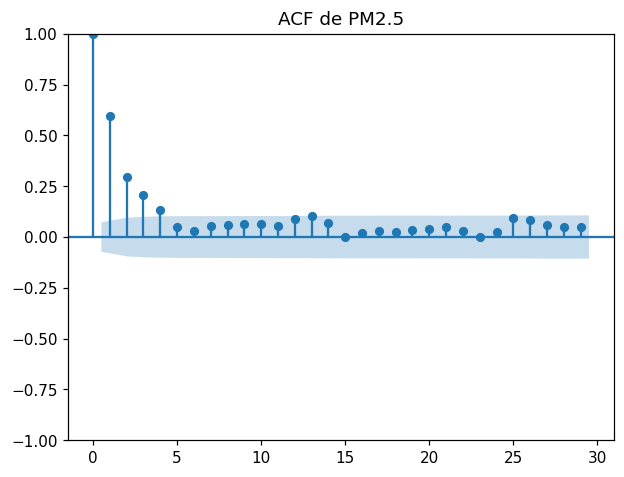

<Figure size 1100x440 with 0 Axes>

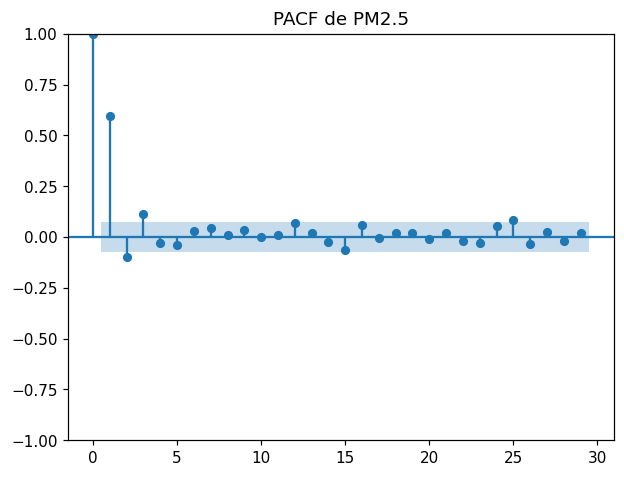

In [20]:
# Serie diaria a analizar
serie = df_daily['PM2.5']

# ACF
plt.figure(figsize=(10,4))
plot_acf(serie.dropna())
plt.title('ACF de PM2.5')
plt.show()

# PACF
plt.figure(figsize=(10,4))
plot_pacf(serie.dropna(), method='ywm')
plt.title('PACF de PM2.5')
plt.show()

Las gráficas ACF y PACF de la serie PM2.5 muestran una alta autocorrelación en los primeros rezagos, lo que sugiere que el comportamiento actual de la serie está fuertemente influenciado por sus valores recientes. En la ACF, la correlación disminuye rápidamente tras los primeros lags, lo que indica que un modelo MA de orden bajo (q=1 o 2) podría ser suficiente. En la PACF, el primer rezago (lag=1) resalta como significativo, mientras que los siguientes caen dentro del intervalo de confianza, lo que sugiere que un modelo AR con p=1 sería un buen punto de partida.

In [21]:
# Aplicar prueba ADF
adf_test = adfuller(serie, autolag='AIC')

# Imprimir resultados
print(f"ADF Statistic: {adf_test[0]:.4f}")
print(f"p-value: {adf_test[1]:.4f}")

# Evaluación rápida
if adf_test[1] < 0.05:
    print(" La serie es estacionaria (rechaza H0)")
else:
    print(" La serie NO es estacionaria (no se rechaza H0), se recomienda diferenciar.")

ADF Statistic: -10.6611
p-value: 0.0000
 La serie es estacionaria (rechaza H0)


In [22]:
# Variable objetivo y variables predictoras
target_col = 'PM2.5'
feature_cols = ['PM10', 'CO', 'O3', 'wspd', 'temp', 'dwpt'] #Variables con mayor correlación con respecto a la variable objetivo

# Split entrenamiento y test
train_y = df_daily[target_col].iloc[:545]    # 1.5 años
test_y = df_daily[target_col].iloc[545:]     # resto del año

train_X = df_daily[feature_cols].iloc[:545]
test_X = df_daily[feature_cols].iloc[545:]


print(f"Training: {len(training_y)} registros ({training_y.index.min()} → {training_y.index.max()})")
print(f"Test: {len(test_y)} registros ({test_y.index.min()} → {test_y.index.max()})")

Training: 13104 registros (2022-01-01 00:00:00 → 2023-06-30 23:00:00)
Test: 185 registros (2023-06-30 00:00:00 → 2023-12-31 00:00:00)


In [23]:
# sarimax_model_d = auto_arima(
#     y=train_y,
#     exogenous=train_X,
#     seasonal=True,          # Activar componente estacional
#     m=30,                   # Estacionalidad mensual observada previamente en la descomposición de la serie
#     start_p=1, max_p=2,                    # Según análisis PACF
#     start_q=1, max_q=2,     # Según análisis ACF
#     start_P=0, max_P=2,
#     start_Q=0, max_Q=2,
#     d=0,                    # Según prueba ADF la serie ya es estacionaria
#     D=None,                 # auto_arima decidirá d y D
#     max_D=1,
#     information_criterion='aic',
#     stepwise=True,
#     trace=True,
#     suppress_warnings=True,
#     n_jobs=1,               # Para reproducibilidad
#     enforce_stationarity=False,
#     enforce_invertibility=False
# )

# # Mostrar resumen del modelo seleccionado
# print(sarimax_model_d.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Resultados en Test (ARIMAX fijo):
RMSE: 2.640
MAE : 1.876
R²  : 0.772


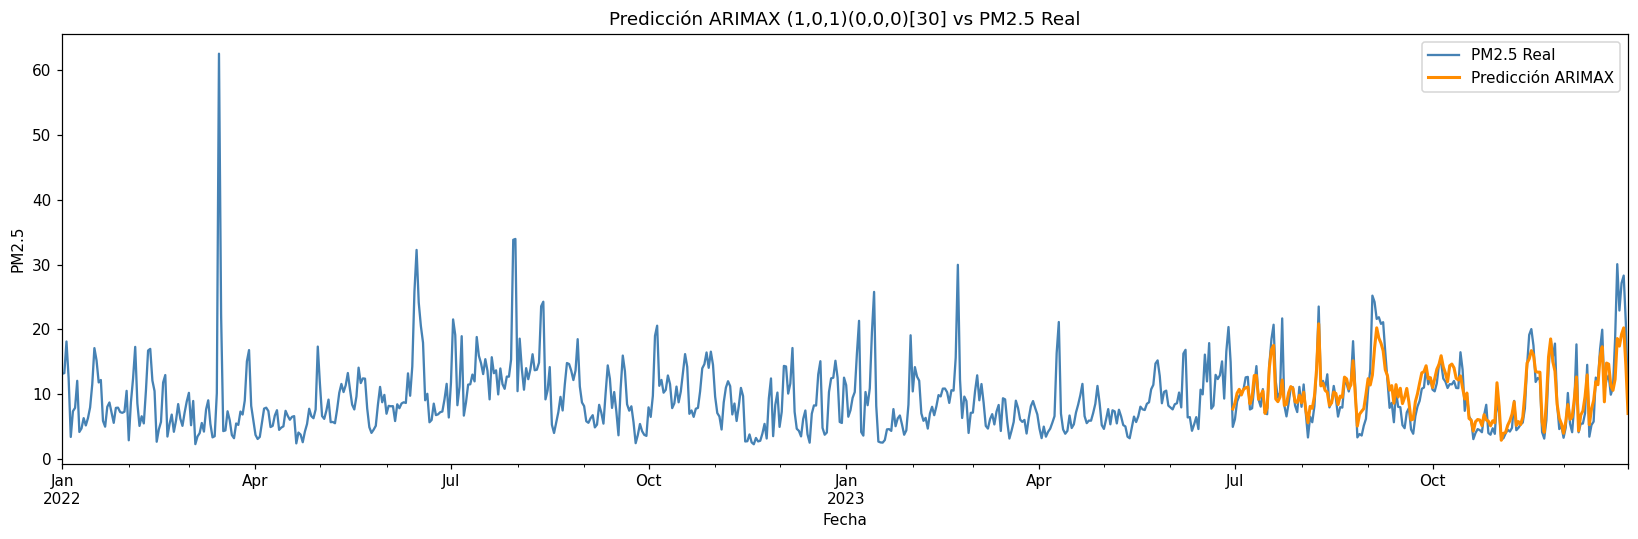

In [24]:
# Definición manual del modelo SARIMAX con los parámetros encontrados
sarimax_model_d = SARIMAX(
    endog=train_y,
    exog=train_X,
    order=(1, 0, 2),             # ARIMA(1,0,1)
    seasonal_order=(0, 0, 0, 30), # periodo m=30
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Ajustar el modelo
sarimax_d_result = sarimax_model_d.fit(disp=False)

# Predecir para el período de test
sarimax_predictions_d = sarimax_d_result.predict(
    start=test_y.index[0],
    end=test_y.index[-1],
    exog=test_X
)

#  Métricas
rmse = np.sqrt(mean_squared_error(test_y, sarimax_predictions_d))
mae  = mean_absolute_error(test_y, sarimax_predictions_d)
r2   = r2_score(test_y, sarimax_predictions_d)
print("\nResultados en Test (ARIMAX fijo):")
print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")
print(f"R²  : {r2:.3f}")

# Graficamos resultados
plt.figure(figsize=(15,5))

# Mostrar TODO 2023
df_daily[target_col].plot(label='PM2.5 Real', color='steelblue')

# Mostrar SOLO predicción en la segunda mitad de 2023
sarimax_predictions_d.plot(label='Predicción ARIMAX', color='darkorange', linewidth=2)
plt.title('Predicción ARIMAX (1,0,1)(0,0,0)[30] vs PM2.5 Real')
plt.xlabel('Fecha'); plt.ylabel('PM2.5')
plt.legend()
plt.tight_layout()
plt.show()

## 3.3 - XGBOOST REGRESSOR

In [25]:
#  Variable objetivo y variables predictoras
target_col = 'PM2.5'
feature_cols = ['PM10','CO', 'O3', 'wspd', 'temp', 'dwpt'] #Variables con mayor correlación con respecto a la variable objetivo

# Definición de traing y test sets
training_y = df_clean_time[target_col].iloc[:13104] # Filas 0-13104 representan el primer año y medio. Desde inicio del 2022 hasta 30 de Junio, 2023.
test_y = df_clean_time[target_col].iloc[13104:17520] # Filas 13104 17520 representan el período entre el año y medio hasta final del segundo año. Desde 30 de Junio, 2023 hasta final del 2023.
training_X = df_clean_time[feature_cols].iloc[:13104]
test_X = df_clean_time[feature_cols].iloc[13104:17520]

In [26]:
# # Obteniendo hiperparametros iniciales de referencia usando RandomizedSearch
# param_dist = {
#     'colsample_bytree': [0.4, 0.5, 0.6],
#     'learning_rate': [0.03, 0.04, 0.05],
#     'max_depth': [1,3,5],
#     'n_estimators': [200, 400, 500],
#     'subsample': [0.6,0.7,0.8],
# }

# xgb = XGBRegressor(random_state=SEED, n_jobs= 1) # Para Reproducibilidad

# # Validación cruzada temporal para evitar fuga de información
# tscv = TimeSeriesSplit(n_splits=3)

# random_search = RandomizedSearchCV(
#     estimator=xgb,
#     param_distributions=param_dist,     # Diccionario de hiperparámetros
#     n_iter=20,                          # Número de combinaciones a probar
#     cv=tscv,                            # Validación cruzada temporal
#     scoring='neg_mean_squared_error',   # Negativo porque sklearn maximiza la métrica
#     verbose=1,
#     n_jobs=-1,                          # Usa todos los núcleos de la CPU para acelerar la búsqueda
#     refit=True,
#     random_state=SEED
# )

# # print("\nIniciando RandomizedSearchCV para XGBoost...")
# random_search.fit(training_X, training_y)

# # Mostrar resultados
# print("\nMejor modelo encontrado:")
# print(random_search.best_estimator_)
# print(f"Mejores hiperparámetros: {random_search.best_params_}")

In [27]:
# # En esta sección se realizaron distintas iteraciones con Gridsearh, usando inicialmente los valores obtenidos por el Randomsearch como hiperparametros

# # Última iteración realizada:
# grid_param = {
#    'colsample_bytree': [0.001,0.002,0.003],
#     'learning_rate': [0.14,0.15,0.16],
#     'max_depth': [1, 2, 3],
#     'n_estimators': [627,628,629],
#     'subsample': [0.65,0.66,0.67]
# }

# xgb = XGBRegressor(random_state=SEED, n_jobs= 1) # Para Reproducibilidad

# # Mejores hiperparámetros: {'colsample_bytree': 0.5, 'learning_rate': 0.45, 'max_depth': 1, 'n_estimators': 625, 'subsample': 0.52}

# # Validación cruzada temporal para evitar fuga de información
# tscv = TimeSeriesSplit(n_splits=3)

# grid_search = GridSearchCV(
#     estimator=xgb,
#     param_grid=grid_param,
#     cv=tscv,
#     scoring='neg_mean_squared_error',  # sklearn maximiza; por eso es negativo
#     verbose=1,
#     n_jobs=-1,
#     refit=True
# )

# print("Iniciando GridSearchCV para XGBoost...")
# grid_search.fit(training_X, training_y)

# # Mostrar mejor modelo y parámetros
# print("\nMejor modelo encontrado:")
# print(grid_search.best_estimator_)
# print(f"Mejores hiperparámetros: {grid_search.best_params_}")

RMSE: 3.312
MAE: 2.276
R²: 0.754


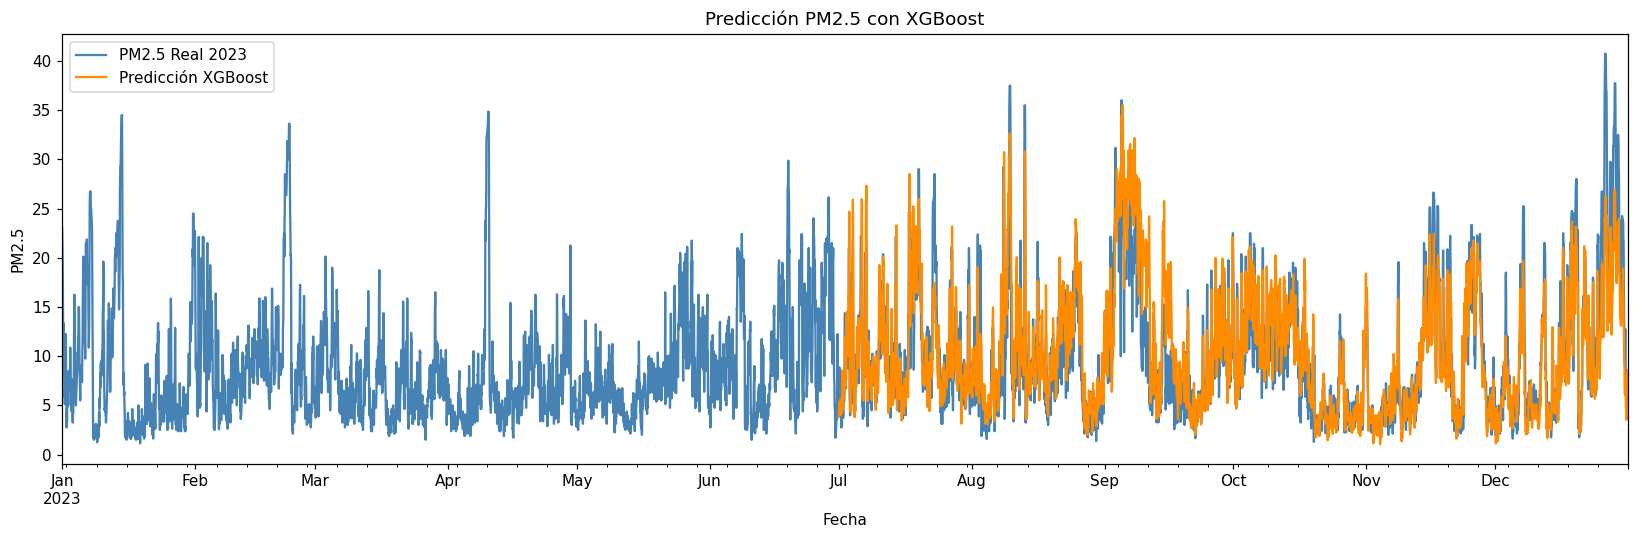

In [40]:
# Mejores hiperparámetros: {'colsample_bytree': 0.001, 'learning_rate': 0.15, 'max_depth': 1, 'n_estimators': 628, 'subsample': 0.66}

# Entrenar Modelo XGBoost  usando mejores hiperparámetros encontrados
xgboost_model = XGBRegressor(
    colsample_bytree=0.001,
    learning_rate=0.15,
    max_depth=1,
    n_estimators=628,
    subsample=0.66,
    random_state=SEED,
    n_jobs=1
)


xgboost_model.fit(training_X, training_y)


# PREDICCIÓN
xgboost_predictions = xgboost_model.predict(test_X)

# Convertir a Series para facilidad en el plot
xgboost_predictions_series = pd.Series(xgboost_predictions, index=test_y.index)

# MÉTRICAS
rmse = np.sqrt(mean_squared_error(test_y, xgboost_predictions))
mae = mean_absolute_error(test_y, xgboost_predictions)
r2 = r2_score(test_y, xgboost_predictions)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")


# Graficamos resultados
plt.figure(figsize=(15, 5))

# Mostrar TODO 2023
df_clean_time[target_col]['2023-01-01':'2023-12-31'].plot(label='PM2.5 Real 2023', color='steelblue')

# Mostrar SOLO predicción en la segunda mitad de 2023
xgboost_predictions_series.plot(label='Predicción XGBoost', color='darkorange')

plt.title('Predicción PM2.5 con XGBoost')
plt.xlabel('Fecha')
plt.ylabel('PM2.5')
plt.legend()
plt.tight_layout()
plt.show()

## 3.4 - LSTM

In [29]:
#  Variable objetivo y variables predictoras
target_col = 'PM2.5'
feature_cols = ['PM10','CO', 'O3', 'wspd', 'temp', 'dwpt'] #Variables con mayor correlación con respecto a la variable objetivo

# Definición de traing y test sets
training_y = df_clean_time[target_col].iloc[:13104] # Filas 0-13104 representan el primer año y medio. Desde inicio del 2022 hasta 30 de Junio, 2023.
test_y = df_clean_time[target_col].iloc[13104:17520] # Filas 13104 17520 representan el período entre el año y medio hasta final del segundo año. Desde 30 de Junio, 2023 hasta final del 2023.
training_X = df_clean_time[feature_cols].iloc[:13104]
test_X = df_clean_time[feature_cols].iloc[13104:17520]

In [30]:
# Normalización. Se escalan los datos al rango [0, 1]
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# variables de entrada (X)
training_X_scaled = scaler_X.fit_transform(training_X)
test_X_scaled = scaler_X.transform(test_X)

#variables de entrada (Y) #Reshape(-1, 1) es necesario para convertir en matriz columna.
training_y_scaled = scaler_y.fit_transform(training_y.values.reshape(-1, 1))
test_y_scaled = scaler_y.transform(test_y.values.reshape(-1, 1))

# Función para crear secuencias para LSTM: Pasos para predecir el siguiente valor
def create_sequences(X, y, seq_length=24):
    Xs, ys = [], []
    for i in range(seq_length, len(X)):
        # Ventanas deslizantes de tamaño seq_length
        Xs.append(X[i-seq_length:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# Definir Longitud de la secuencia (ventana temporal) de 24 horas
seq_length = 24

# Crear las secuencias para entrenamiento y test. Todos con tamaño 24
X_train_seq, y_train_seq = create_sequences(training_X_scaled, training_y_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(test_X_scaled, test_y_scaled, seq_length)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train_seq_final, X_val_seq, y_train_seq_final, y_val_seq = train_test_split(
    X_train_seq, y_train_seq, test_size=0.2, shuffle=False
)

In [31]:
# def build_model(hp):
#     # Re-fijar semillas dentro del trial
#     reset_seeds(SEED)

# # Definición de hiperparametros a buscar. Aqui se realizaron varias iteraciones hasta obtener el mejor modelo, similar al gridsearch hecho para XGBoost
# # Última iteración realizada:
#     lstm_units  = hp.Choice('lstm_units', [53,54,55])
#     dense_units = hp.Choice('dense_units', [3,4,5])
#     dropout_p   = hp.Choice('dropout_rate', [0.5,0.55,0.60,0.65,0.75])
#     opt_choice  = hp.Choice('optimizer', ['adam'])
#     lr          = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

#     # Inicializadores con seed
#     k_init = initializers.GlorotUniform(seed=SEED)
#     r_init = initializers.Orthogonal(seed=SEED)
#     b_init = initializers.Zeros()

#     #Definición del modelo
#     model = Sequential()
#     model.add(Input(shape=(seq_length, X_train_seq.shape[2])))
#     model.add(                                                                                  # Capa LSTM
#         LSTM(
#             lstm_units,
#             return_sequences=False,
#             kernel_initializer=k_init,
#             recurrent_initializer=r_init,
#             bias_initializer=b_init
#         )
#     )
#     model.add(Dropout(dropout_p, seed=SEED))                                                     # % Dropout
#     model.add(Dense(dense_units, activation='relu',                                              # Capa Densa Oculta
#                     kernel_initializer=k_init, bias_initializer=b_init))
#     model.add(Dense(1, kernel_initializer=k_init, bias_initializer=b_init))                      # Capa Densa de Salida

#     optimizer = Adam(learning_rate=lr)    # Optimizador
#     model.compile(optimizer=optimizer, loss='mse')
#     return model

# # Limpia el directorio del tuner para que siempre la busqueda comience de cero
# shutil.rmtree("lstm_tuning_opt", ignore_errors=True)

# # Configuración del Tuner usando Optimización Bayesiana
# tuner = kt.BayesianOptimization(
#     build_model,
#     objective='val_loss',
#     max_trials=20,
#     seed=SEED,
#     directory='lstm_tuning_opt',
#     project_name='pm25_forecast',
#     overwrite=True
# )

# # callback de Keras que detiene el entrenamiento temprano (early stopping) para evitar overfitting
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Busqueda de hiperparámetros
# tuner.search(
#     X_train_seq_final, y_train_seq_final,
#     validation_data=(X_val_seq, y_val_seq),
#     epochs=100,
#     batch_size=64,
#     callbacks=[early_stop],
#     verbose=1,
#    # Keras Tuner pasa los kwargs a model.fit:
#     shuffle=False
# )

# # Obtener el mejor modelo y sus hiperparámetros
# lstm_model = tuner.get_best_models(1)[0]
# best_hps = tuner.get_best_hyperparameters(1)[0]

# print("\nMejores hiperparámetros encontrados:")
# print(best_hps.values)

# # Mejores hiperparámetros encontrados: {'lstm_units': 54, 'dense_units': 4, 'dropout_rate': 0.55, 'optimizer': 'adam', 'learning_rate': 0.00410319631213131}

In [32]:
# Hiperparámetros finales
lstm_units  = 54
dense_units = 4
dropout_p   = 0.55
lr          = 0.00410319631213131

# Inicializadores con seed
k_init = initializers.GlorotUniform(seed=SEED)
r_init = initializers.Orthogonal(seed=SEED)
b_init = initializers.Zeros()

# Construcción del modelo
lstm_model = Sequential()
lstm_model.add(Input(shape=(seq_length, X_train_seq.shape[2])))  # input shape
lstm_model.add(
    LSTM(
        lstm_units,
        return_sequences=False,
        kernel_initializer=k_init,
        recurrent_initializer=r_init,
        bias_initializer=b_init
    )
)
lstm_model.add(Dropout(dropout_p, seed=SEED))
lstm_model.add(Dense(dense_units, activation='relu',
                kernel_initializer=k_init, bias_initializer=b_init))
lstm_model.add(Dense(1, kernel_initializer=k_init, bias_initializer=b_init))

optimizer = Adam(learning_rate=lr)
lstm_model.compile(optimizer=optimizer, loss='mse')

# Entrenamiento con early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = lstm_model.fit(
    X_train_seq_final, y_train_seq_final,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=64,
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0100 - val_loss: 0.0027
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 8/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 9/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 10/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 11/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 12/100
164/164 ━━━━━━━━━

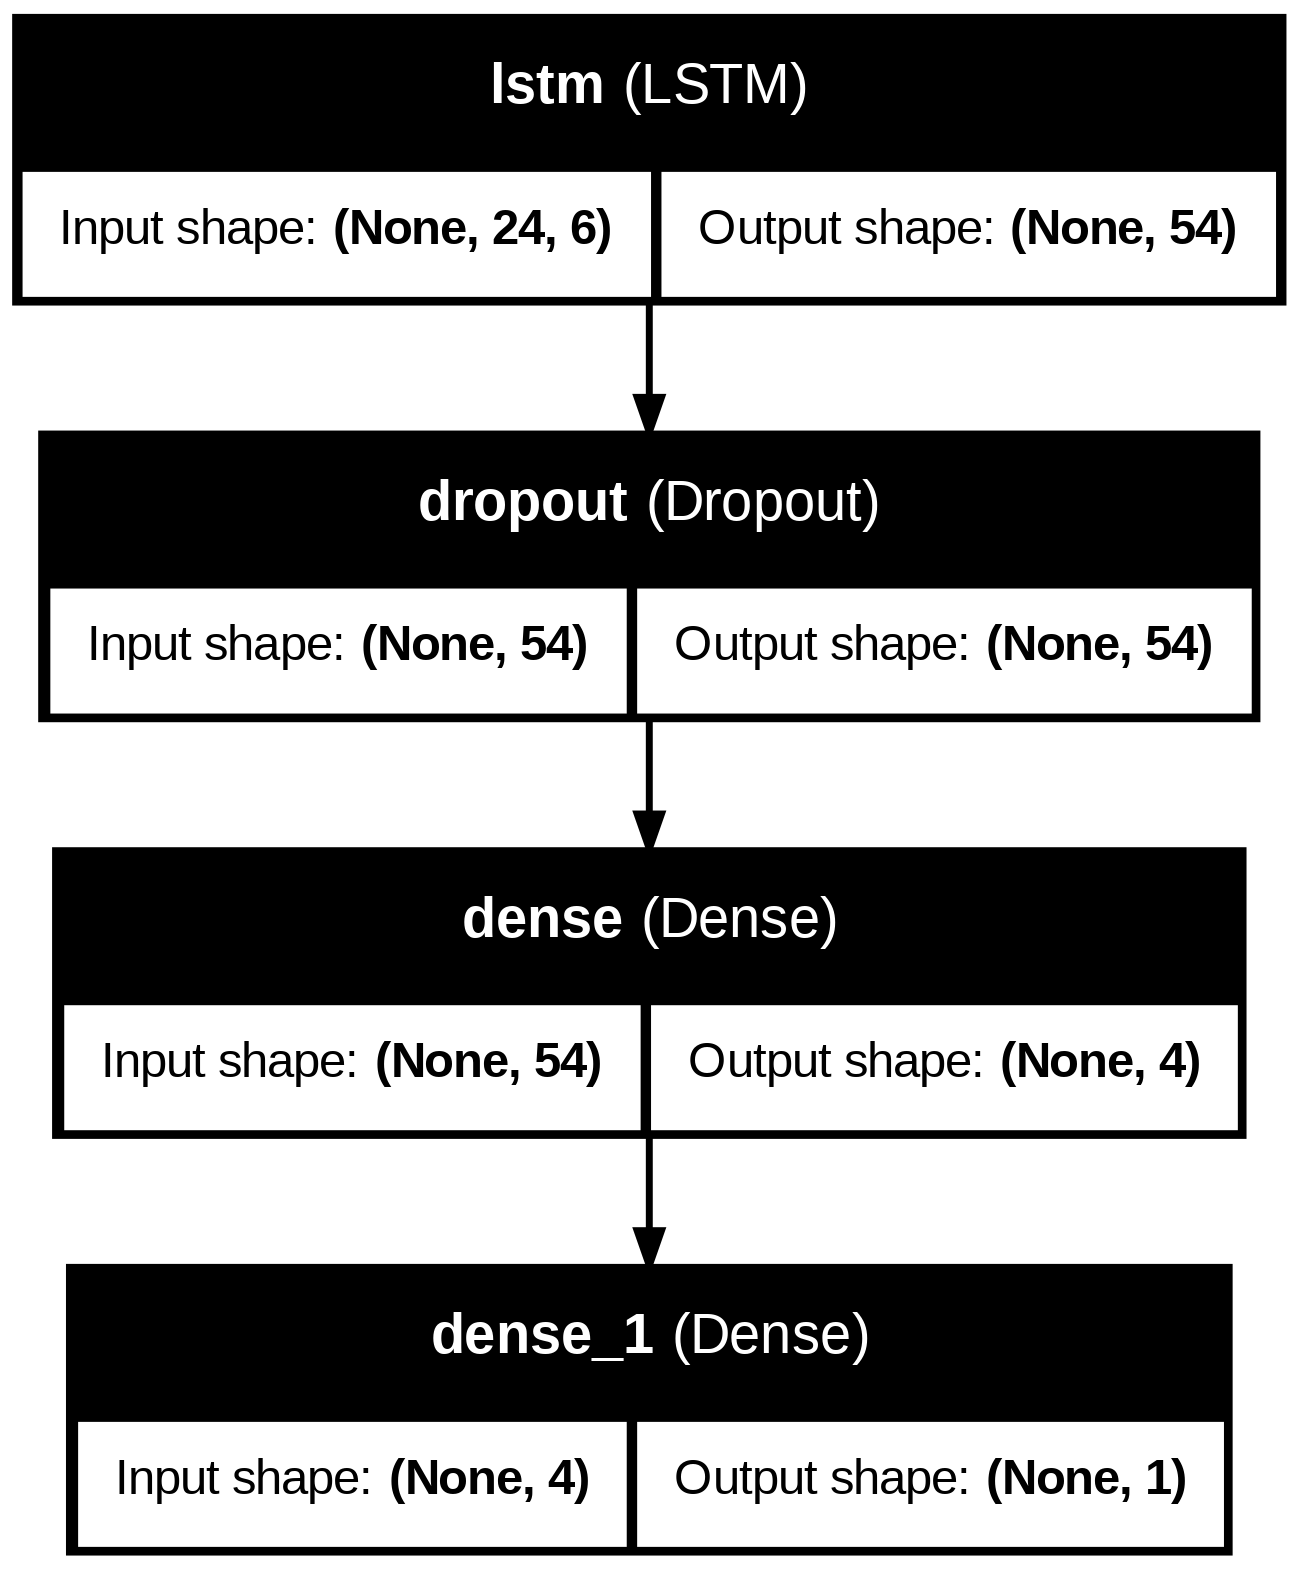

In [34]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

plot_model(
    lstm_model,
    to_file="lstm_model_vertical.png",
    show_shapes=True,          # quítalo si aún queda grande
    show_layer_names=True,     # quítalo si aún queda grande
    rankdir="TB",              # vertical
    dpi=250                    # baja el DPI para que el PNG sea más pequeño
)

display(Image("lstm_model_vertical.png", width=420))  # fuerza ancho pequeño en notebook

RMSE: 3.335
MAE:  2.489
R²:   0.751


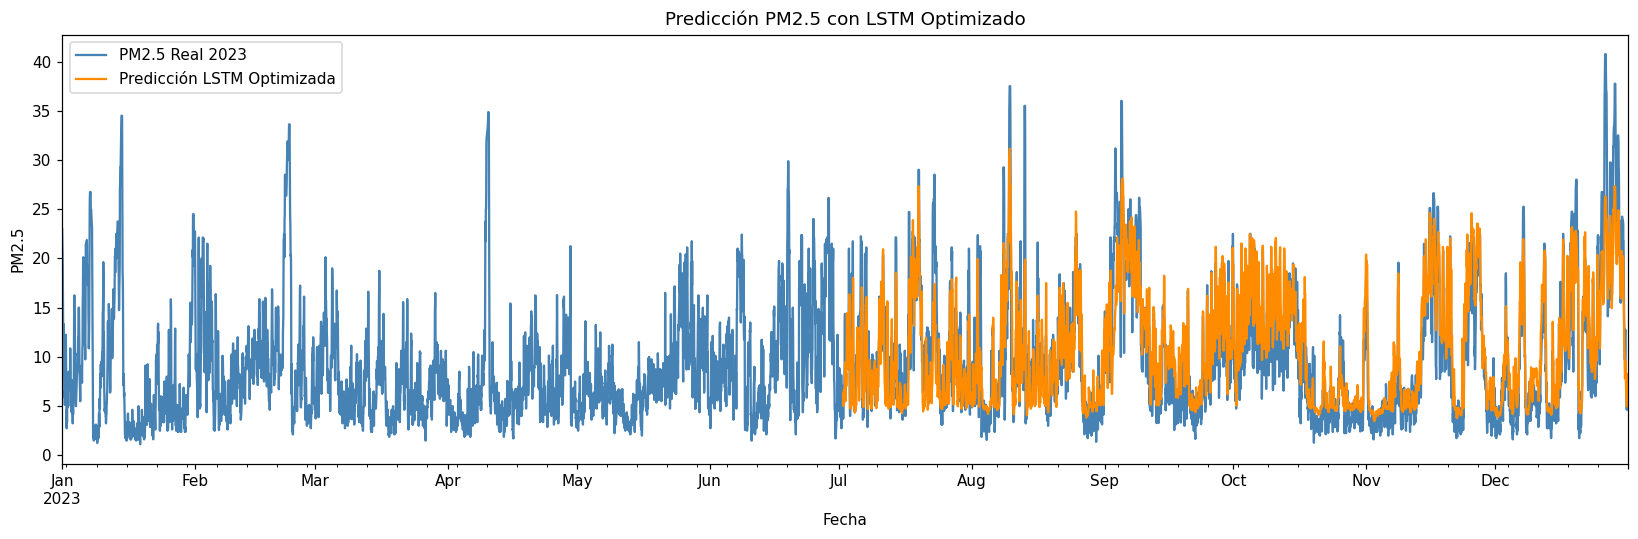

In [41]:
# Evaluacion
y_pred_scaled = lstm_model.predict(X_test_seq, verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_test_true = scaler_y.inverse_transform(y_test_seq).flatten()
pred_index = test_y.index[seq_length:]

rmse = np.sqrt(mean_squared_error(y_test_true, y_pred))
mae = mean_absolute_error(y_test_true, y_pred)
r2 = r2_score(y_test_true, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.3f}")


# Graficamos resultados
plt.figure(figsize=(15, 5))

# Mostrar TODO 2023
df_clean_time[target_col]['2023-01-01':'2023-12-31'].plot(label='PM2.5 Real 2023', color='steelblue')

# Mostrar SOLO predicción en la segunda mitad de 2023
pd.Series(y_pred, index=pred_index).plot(label='Predicción LSTM Optimizada', color='darkorange')
plt.title('Predicción PM2.5 con LSTM Optimizado')
plt.xlabel('Fecha')
plt.ylabel('PM2.5')
plt.legend()
plt.tight_layout()
plt.show()

## 3.5 - Ensamble


Fitting 3 folds for each of 720 candidates, totalling 2160 fits
Mejores parámetros: {'colsample_bytree': 1e-05, 'learning_rate': 0.12, 'max_depth': 1, 'n_estimators': 506, 'subsample': 0.14}
RMSE: 3.306
MAE:  2.277
R²:   0.756


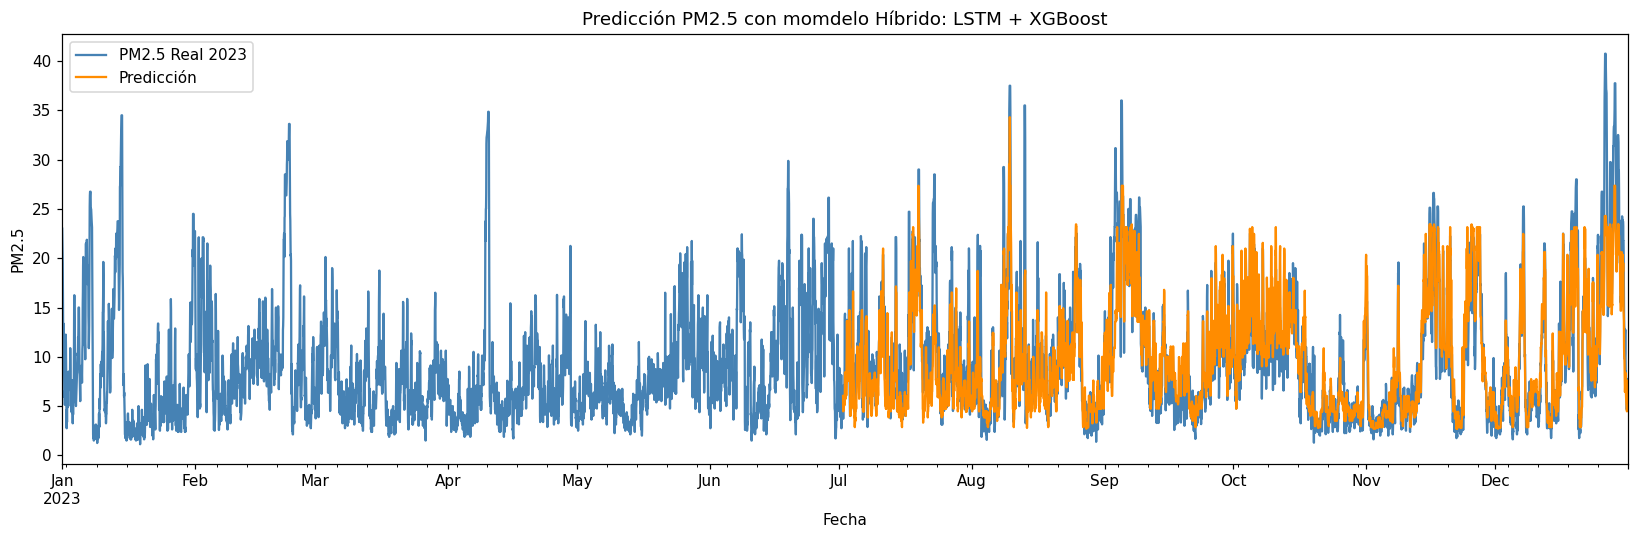

In [43]:
# Construir un extractor de características latentes eliminando la última capa de salida
n_feats = X_train_seq.shape[2]
inp = tf.keras.Input(shape=(seq_length, n_feats)) # Se define una nueva entrada para un modelo funcional
x = inp
for layer in lstm_model.layers[:-1]: # Se copian todas las capas del LSTM original, excepto la última capa de salida
    x = layer(x)
feature_extractor = tf.keras.Model(inp, x) #Se crea un nuevo modelo funcional, cuya salida no es la predicción final del LSTM, sino las activaciones de la última capa oculta

# Generar representaciones latentes para train y test
train_latent = feature_extractor.predict(X_train_seq_final, verbose=0)
test_latent  = feature_extractor.predict(X_test_seq,        verbose=0)

# Definir un micro-grid alrededor de los mejores hiperparámetros obtenidos en el XGBoost puro
reset_seeds(SEED)

param_grid = {
    "colsample_bytree":  [0.00001,0.00002,0.00004,0.00003,0.00005],
    "learning_rate":     [0.10,0.11,0.12,0.13],
    "max_depth":         [1,2,3],
    "n_estimators":      [505,506,507],
    "subsample":         [0.12,0.13,0.14,0.15],
}

# Mejores parámetros XGBoost (micro-grid sobre latentes LSTM): {'colsample_bytree': 0.0001, 'learning_rate': 0.12, 'max_depth': 1, 'n_estimators': 505, 'subsample': 0.15}{

xgb = XGBRegressor(random_state=SEED, n_jobs=1)

# Validación cruzada temporal para evitar fuga de información
tscv = TimeSeriesSplit(n_splits=3)

# Se usa MSE negativo (por convención de sklearn: mayor es mejor)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',  # Negativo porque sklearn maximiza la métrica
    verbose=1,
    n_jobs=-1,
    refit=True
)

# Ajusta el micro-grid sobre las features latentes del conjunto de entrenamiento
grid_search.fit(train_latent, y_train_seq_final.ravel())

# Recupera el mejor modelo y sus parámetros
xgboost_model = grid_search.best_estimator_
print("Mejores parámetros:", grid_search.best_params_)

# Predicciones en test y desescalado
stacking_pred_scaled = xgboost_model.predict(test_latent)
stacking_pred = scaler_y.inverse_transform(stacking_pred_scaled.reshape(-1, 1)).flatten()
y_test_true   = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

# Métricas
rmse = np.sqrt(mean_squared_error(y_test_true, stacking_pred))
mae  = mean_absolute_error(y_test_true, stacking_pred)
r2   = r2_score(y_test_true, stacking_pred)
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.3f}")

# Gráfico
pred_index = test_y.index[seq_length:]
plt.figure(figsize=(15,5))
df_clean_time[target_col]['2023-01-01':'2023-12-31'].plot(label='PM2.5 Real 2023', color='steelblue')
pd.Series(stacking_pred, index=pred_index).plot(label='Predicción', color='darkorange')
plt.title('Predicción PM2.5 con momdelo Híbrido: LSTM + XGBoost')
plt.xlabel('Fecha')
plt.ylabel('PM2.5')
plt.legend()
plt.tight_layout()
plt.show()

Tabla Resumen:

| Modelo              | RMSE (Sin tratar) | RMSE (Tratado) | MAE (Sin tratar) | MAE (Tratado) | R² (Sin tratar) | R² (Tratado) |
|---------------------|-------------------|----------------|------------------|----------------|------------------|---------------|
| SARIMAX Horario     | 3.64              | 3.86           | 2.46             | 2.49           | 0.723            | 0.665         |
| SARIMAX Diario      | 2.811             | 2.640          | 2.026            | 1.876          | 0.753            | 0.772         |
| XGBoost             | 3.560             | 3.312          | 2.415            | 2.276          | 0.736            | 0.754         |
| LSTM                | 3.372             | 3.335          | 2.453            | 2.489          | 0.763            | 0.751         |
| Ensemble XGB + LSTM | 3.298             | 3.306          | 2.223            | 2.277          | 0.774            | 0.756         |




- SARIMAX horario empeoró tras el tratamiento de outliers: esto puede deberse a que el modelo originalmente ya capturaba bien los valores extremos, y reemplazarlos con la media/mediana/rolling median afectó su capacidad predictiva.

-  SARIMAX diario mejoró ligeramente, lo cual es un buen indicio de que a nivel agregado (día), el tratamiento ayudó.

-  XGBoost mejoró en todos los aspectos, lo cual concuerda con la teoria, ya que ésta sugiere que este modelo, cuando usa MSE (o su negativo) como métrica, los outliers tienen un impacto mayor porque el error cuadrático penaliza valores extremos más fuertemente.

-  LSTM y el ensemble variaron poco. En general, LSTM es sensible a outliers pero parece que para nuestra data, es robusto a outliers moderados. En el ensemble también se mantuvo sólido.

Conclusiones:

No todos los modelos se benefician del tratamiento de outliers. Algunos modelos como SARIMAX en alta frecuencia sufren más con la eliminación o imputación agresiva.

Modelos basados en árboles (como XGBoost) sí se benefician de datos suavizados, ya que son sensibles a valores extremos.

LSTM y ensembles son estables, pero no siempre ganan tras el tratamiento.